# Business Problem

Air pollution is a growing concern worldwide, impacting both the environment and human health. To support proactive decision-making, it is essential to develop models that can accurately classify air quality based on measurable environmental and demographic factors.

This project aims to create a machine learning model that classifies air quality levels (Good, Moderate, Poor, or Hazardous) with a target performance of over 75% accuracy (or equivalent metric such as F1-score). Such a model can assist policymakers, environmental agencies, and communities in monitoring pollution and mitigating its effects.

# Project Objectives

1. Preprocess and Clean the Dataset
Handle missing values, outliers, and ensure the dataset is well-formatted for modeling.

2. Explore and Analyze Feature Relationships
Understand the impact of environmental and demographic variables on air quality levels through visualizations and correlation analysis.

3. Train Classification Models and Evaluate Performance
Apply classification algorithms (Logistic Regression, Decision Trees, Random Tress, XGBoost) and optimize them to achieve at least 75% accuracy or equivalent performance.

4. Select the Best Model and Interpret Results
Pick the model that works best and use it to draw recommendations

# Dataset Overview

The dataset contains 5,000 records, each representing air quality observations in a specific region. The key features include:

- Temperature (°C)

- Humidity (%)

- PM2.5, PM10 (µg/m³)

- NO2, SO2 (ppb)

- CO (ppm)

- Proximity to Industrial Areas (km)

- Population Density (people/km²)

- Target: Air Quality Level (Good, Moderate, Poor, Hazardous)

# Tools Used

Python (Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn)

Jupyter Notebook

Classification Models (Logistic Regression, Decision Tress)


## Step 1: Load Data, Inspect and Preprocess

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler,label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, make_scorer, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [2]:
# Load the data
df = pd.read_csv('updated_pollution_dataset.csv')
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


In [3]:
# check for the info
print(df.info())
print(f'The dataset has {df.shape[1]} columns and {df.shape[0]} rows')
# for column in df.columns:
#     print(f'The column "{column}" is of type {df[column].dtype}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB
None
The dataset has 10 columns and 5000 rows


In [4]:
# check for duplicates
duplicates = df.duplicated()
print(f' Number of duplicates: {sum(duplicates)}')

 Number of duplicates: 0


There are no duplicates in the dataset

In [5]:
# check for missing values
df.isna().sum()

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64

The dataset is clean as it has no missing values

In [6]:
# check for outliers in numerical columns

# Select only numerical columns
numeric_cols = df.select_dtypes(include='number')

# Calculate IQR for each numeric column
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Identify rows with outliers
outlier_mask = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))
df_outliers = df[outlier_mask.any(axis=1)]

print(f"Number of rows with outliers: {df_outliers.shape[0]}")



Number of rows with outliers: 593


In [7]:
# replace outliers with median

df_imputed = numeric_cols.copy()

for col in numeric_cols.columns:
    lower = Q1[col] - 1.5 * IQR[col]
    upper = Q3[col] + 1.5 * IQR[col]
    median = df_imputed[col].median()
    df_imputed[col] = df_imputed[col].apply(
        lambda x: median if x < lower or x > upper else x
    )

# Replace in original DataFrame
df[numeric_cols.columns] = df_imputed
df_imputed


,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319.0
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611.0
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619.0
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551.0
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303.0
...,...,...,...,...,...,...,...,...,...
4995,40.6,74.1,12.0,21.7,45.5,25.7,2.11,2.8,765.0
4996,28.1,96.9,6.9,25.0,25.3,10.8,1.54,5.7,709.0
4997,25.9,78.2,14.2,22.1,34.8,7.8,1.63,9.6,379.0
4998,25.3,44.4,21.4,29.0,23.7,5.7,0.89,11.6,241.0


In [8]:
# Rejoin the categorical columns to the imputed dataframe

# Get the categorical columns from the original DataFrame
categorical_cols = df.select_dtypes(exclude='number')

# Concatenate imputed numeric and original categorical columns
df_final = pd.concat([df_imputed, categorical_cols], axis=1)

df_final.head()


,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319.0,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611.0,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619.0,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551.0,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303.0,Good


## Step 2: Perform Exploratory Data Analysis (EDA)

In [9]:
# check for the decriptive statistics 
df_final.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,29.713060,69.870940,14.730400,24.645420,26.009500,9.44880,1.483540,8.381560,496.798400
std,6.218252,15.576654,13.152195,16.169856,8.284051,5.85351,0.518861,3.531162,151.849148
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.20000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.10000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.00000,1.410000,7.900000,494.000000
75%,33.700000,80.200000,20.625000,32.400000,31.325000,12.90000,1.820000,11.000000,600.000000
max,47.300000,113.100000,58.300000,76.800000,49.500000,26.60000,3.040000,19.400000,927.000000


In [10]:
# check for target class imbalance
df_final['Air Quality'].value_counts()

Air Quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64

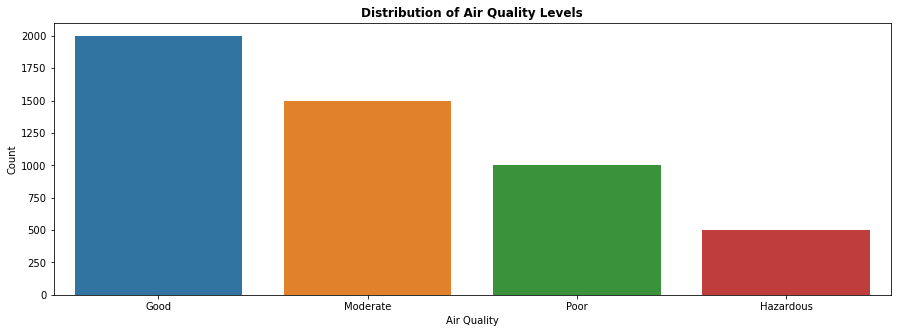

In [11]:
# plot a countplot of the target class
plt.figure(figsize=(15, 5))
sns.countplot(x='Air Quality', data=df_final, order=['Good', 'Moderate', 'Poor', 'Hazardous'])
plt.title('Distribution of Air Quality Levels', fontweight = 'bold')
plt.ylabel('Count')
plt.xlabel('Air Quality')
plt.show()

-> The dataset is imbalanced although not severe, we can impute using Smote

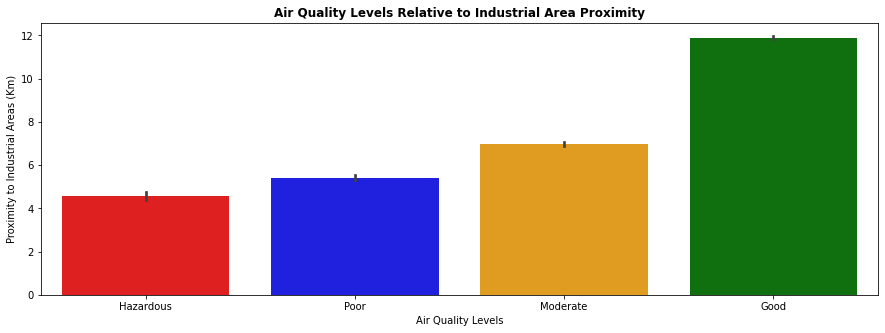

In [12]:
# plot a graph of air quality against Proximity_to_Industrial_Areas

plt.figure(figsize=(15, 5))
custom_palette = {
    'Good': 'green',
    'Moderate': 'orange',   
    'Poor': 'blue',       
    'Hazardous': 'red'
}

# groupby the columns and sort them out by their index
order = df_final.groupby('Air Quality')['Proximity_to_Industrial_Areas'].mean().sort_values().index

sns.barplot(x=df_final['Air Quality'], y=df_final['Proximity_to_Industrial_Areas'], order=order,  palette=custom_palette)

plt.title('Air Quality Levels Relative to Industrial Area Proximity',fontweight = 'bold')
plt.xlabel('Air Quality Levels')
plt.ylabel('Proximity to Industrial Areas (Km)')
plt.show();


-> This graph indicates that the closer an area is to an industrial area, the more polluted the air quality tends to be.

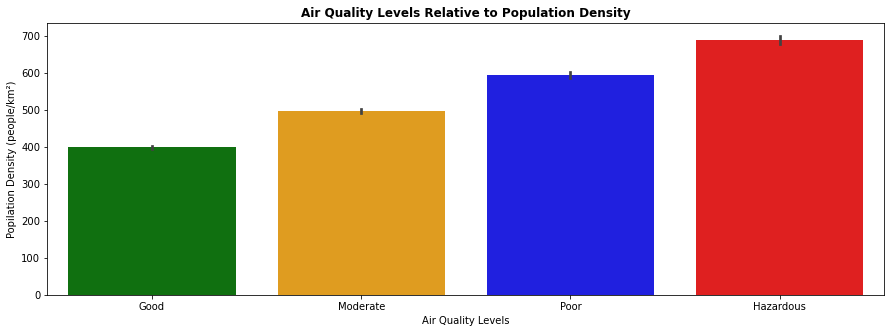

In [13]:
# Plot a graph of air quality levels against population density

plt.figure(figsize=(15, 5))
custom_palette = {
    'Good': 'green',
    'Moderate': 'orange',   
    'Poor': 'blue',       
    'Hazardous': 'red'
}

# groupby the columns and sort them out by their index
order = df_final.groupby('Air Quality')['Population_Density'].mean().sort_values().index

sns.barplot(x=df_final['Air Quality'], y=df_final['Population_Density'], order=order, palette=custom_palette)

plt.title('Air Quality Levels Relative to Population Density', fontweight = 'bold')
plt.xlabel('Air Quality Levels')
plt.ylabel('Popilation Density (people/km²)')
plt.show();


-> This graph indicates that areas with larger populations tend to have more polluted or hazardous air, while less         populated areas generally experience better air quality.

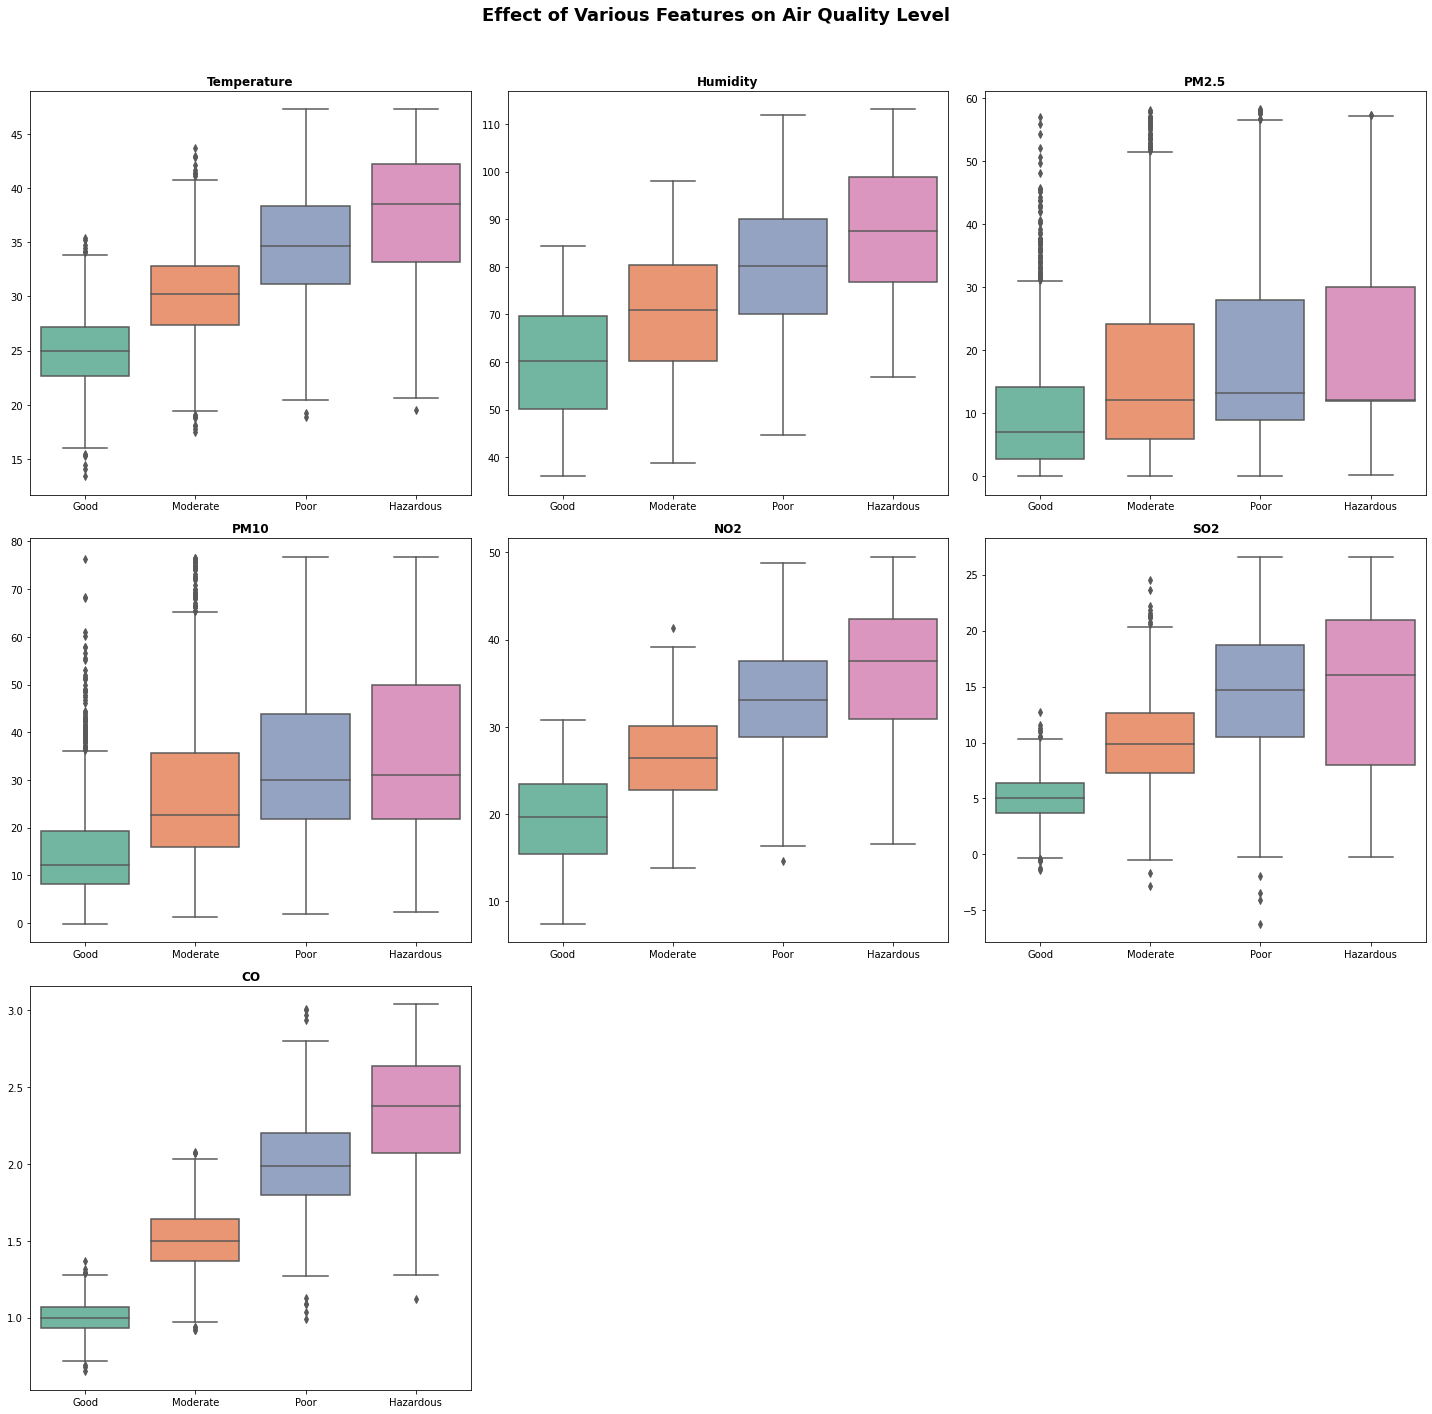

In [14]:
# Plot a boxplot of the air quality against he other remaining features

# Set plot style and size
plt.figure(figsize=(20, 20))
plt.suptitle('Effect of Various Features on Air Quality Level', fontsize=18, fontweight='bold')

features = [
    'Temperature', 
    'Humidity', 
    'PM2.5', 
    'PM10', 
    'NO2', 
    'SO2', 
    'CO'
]

order = ['Good', 'Moderate', 'Poor', 'Hazardous']

# Create subplots for each feature
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Air Quality', y=feature, data=df_final, palette='Set2', order=order)
    plt.title(feature, fontsize=12, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- From the boxplots, it's clear that PM2.5 and PM10 levels go up as the air quality gets worse, from Good to Hazardous. This means they play a big role in how bad the air is.

- CO also rises with poor air quality, so it's another important factor.

- NO2 and SO2 change a bit across the different air quality levels, but not as much. They still have some effect, just not as strong.

- Humidity and Temperature don’t seem to change much between the categories, so they probably don’t affect air quality that much.

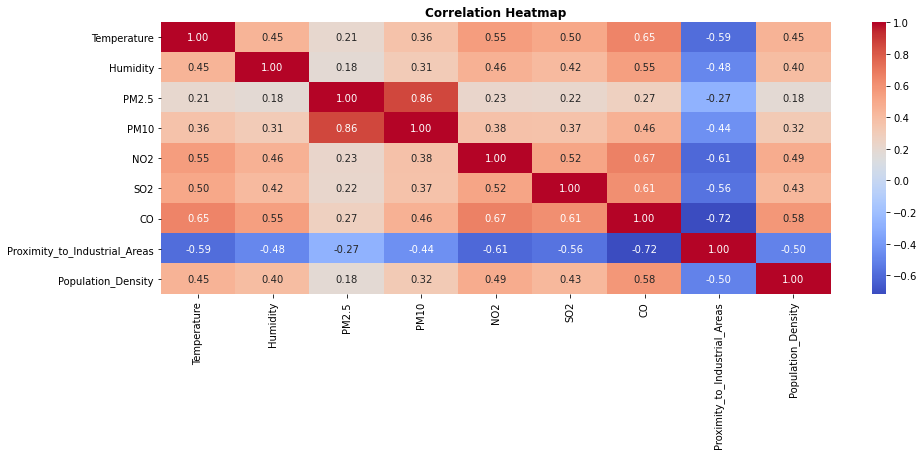

In [15]:
# Plot a correlation for the numeric columns only 

plt.figure(figsize=(15,5))
sns.heatmap(df_final.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap', fontweight = 'bold')
plt.show();


- PM2.5 and PM10 are strongly related and both increase when air quality gets worse.

- PM2.5, PM10, NO2, and CO have a strong positive correlation with the Air Quality Index (AQI), meaning they are major contributors to air pollution.

- SO2 and Temperature have a weaker impact on AQI compared to other pollutants.

- Proximity to industrial areas shows a negative correlation with AQI, meaning the farther a place is from industrial zones, the better its air quality. This is expected since factories often release pollutants, so areas closer to them tend to have worse air quality.

- Population density is most strongly linked to CO levels because many everyday human activities release carbon (II) oxide.

- Humidity is negatively related to pollution - higher humidity usually means better air quality because moisture helps settle dust and pollutants.

## Step 3: Modelling

## (i) Modelling Preprocessing

Since the target variable is multiclass, it needs to be label encoded before being used in modeling.

In [16]:
# Encode the target variable

le = LabelEncoder()
df_final['Air Quality Encoded'] = le.fit_transform(df_final['Air Quality'])

# Convert encoded values to float
df_final['Air Quality Encoded'] = df_final['Air Quality Encoded'].astype(float)

# Check mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'Good': 0, 'Hazardous': 1, 'Moderate': 2, 'Poor': 3}


In [17]:
# perfom a train test split

X = df_final.drop(columns=['Air Quality', 'Air Quality Encoded'])
y = df_final['Air Quality Encoded']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
4227,38.8,92.5,8.3,29.0,32.8,8.3,2.19,3.9,698.0
4676,26.3,54.1,0.9,10.3,25.1,4.5,0.95,10.1,316.0
800,37.2,111.3,0.2,8.8,31.9,18.5,2.12,7.7,753.0
3671,17.5,57.2,8.7,13.6,25.6,3.1,1.03,11.6,505.0
4193,26.7,54.8,5.8,11.3,15.8,4.5,1.25,11.8,565.0
...,...,...,...,...,...,...,...,...,...
4426,30.0,59.7,12.0,68.8,22.1,7.4,1.39,5.1,412.0
466,27.7,54.0,17.6,23.2,24.6,11.1,1.27,7.8,638.0
3092,24.2,67.6,19.4,35.1,24.2,9.6,1.91,6.2,422.0
3772,21.4,76.4,15.3,22.1,12.4,3.4,0.96,16.3,420.0


In [18]:
# Scale the X values using MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create DataFrame for scaled training data
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_df
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_test_scaled_df

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
1501,0.528024,0.485084,0.205832,0.284416,0.425178,0.710366,0.790795,0.005917,0.767253
2586,0.312684,0.425422,0.013722,0.114286,0.320665,0.262195,0.213389,0.473373,0.063599
2653,0.353982,0.552529,0.070326,0.089610,0.330166,0.466463,0.313808,0.449704,0.480379
1055,0.510324,0.856031,0.135506,0.341558,0.812352,0.984756,0.694561,0.136095,0.780785
705,0.386431,0.234760,0.210978,0.201299,0.306413,0.350610,0.142259,0.603550,0.251691
...,...,...,...,...,...,...,...,...,...
4711,0.601770,0.412451,0.090909,0.088312,0.332542,0.490854,0.246862,0.295858,0.254398
2313,0.271386,0.324254,0.322470,0.336364,0.180523,0.256098,0.154812,0.721893,0.148850
3214,0.516224,0.732815,0.416810,0.388312,0.653207,0.737805,0.414226,0.390533,0.663058
2732,0.424779,0.617380,0.406518,0.487013,0.444181,0.439024,0.238494,0.289941,0.313938


In [31]:
# Use SMOTE to oversample and solve the imbalance

smt = SMOTE()
X_train_resampled, y_train_resampled = smt.fit_resample(X_train_df,y_train)

# Create DataFrame for X_train_resampled
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train_df.columns)

# Create DataFrame for y_train_resampled
y_train_resampled_df = y_train_resampled.to_frame(name='Target')

# check the shapes and balancing
print(X_train_resampled_df.shape)
print(y_train_resampled_df.shape)
X_train_resampled_df.head(), y_train_resampled_df.head()

y_train_resampled.value_counts()

(6364, 9)
(6364, 1)


Air Quality Encoded
1.0    1591
0.0    1591
3.0    1591
2.0    1591
Name: count, dtype: int64

## (ii) Build a logistic regression model using statsmodels

In [30]:
# Add constant
X_train_const = sm.add_constant(X_train_resampled_df)

# Fit Multinomial Logistic Regression
model = sm.MNLogit(y_train_resampled_df, X_train_const).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.282815
         Iterations 14
                          MNLogit Regression Results                          
Dep. Variable:                 Target   No. Observations:                 6364
Model:                        MNLogit   Df Residuals:                     6334
Method:                           MLE   Df Model:                           27
Date:                Mon, 02 Jun 2025   Pseudo R-squ.:                  0.7960
Time:                        13:19:52   Log-Likelihood:                -1799.8
converged:                       True   LL-Null:                       -8822.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     Target=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           -71.0188      3.913    -18.151      0

### Model Interpretation

- Pseudo R-squares = 0.7960; The model explains 79.6% of the variability in air quality categories.

- LLR p-value = 0.000; The model is statistically significant

### Below is a breakdown of the predictors and how they influence the air quality

→ CO (Carbon (II) Oxide) – Coefficient: 77.53

 - The strongest positive predictor. A one-unit increase in CO greatly increases the likelihood of poor air quality.

→ NO2 (Nitrogen (IV) Oxide) – Coefficient: 29.34

 - A strong positive contributor. Higher NO2 levels significantly raise the chance of poor air quality

→ SO2 (Sulfur (IV) Oxide) – Coefficient: 25.87

 - Significantly increases the likelihood of poor air quality.

→ Proximity to Industrial Areas – Coefficient: -31.79

 - Strong negative effect. As distance from industrial areas decreases, the risk of poor air quality increases sharply.

→ Temperature – Coefficient: 27.80

 - Higher temperatures are associated with worse air quality, possibly due to enhanced chemical reactions or trapped pollutants.

→ Population Density – Coefficient: 17.26

 - Densely populated areas are more likely to have poor air quality due to more pollution from human activities.

→ Humidity – Coefficient: 13.43

- Moderately increases the likelihood of poor air quality, possibly due to its effect on particle suspension and chemical interactions.

→ PM10 (Coarse Particulate Matter) – Coefficient: 14.64

 - Has a mild positive effect. Higher PM10 slightly increases the chance of poor air quality.

→ PM2.5 (Fine Particulate Matter) – Coefficient: -8.67

- Although statistically significant, PM2.5 shows a negative effect, suggesting that higher levels are associated with better air quality, which may warrant further investigation.
 
### Conclusion

- The strongest predictors of poor air quality are CO, NO₂, SO₂, temperature, population density, and proximity to industrial areas.

- Humidity and PM10 show moderate influence on air quality.

- While PM2.5 is often used as a key pollution metric, it showed a weak negative relationship in this model and may not be a strong standalone predictor in this case.

- The model highlights key areas to target for pollution control, such as industrial zones and densely populated areas. Further refinement could explore non-linear patterns or interactions between variables.

### Why PM2.5 and PM10 May Seem Important, But Don’t Stand Out in Regression Models 

Even though PM2.5 and PM10 levels rise as air quality worsens as clearly shown in boxplots and correlation matrices, they don't emerge as strong predictors in logistic regression models. This is likely due to multicollinearity, where PM2.5 and PM10 are highly correlated with each other and with other pollutants like CO, NO₂, and SO₂. Such overlap makes it challenging for the regression model to determine the unique impact of each pollutant, leading to inflated standard errors and less reliable coefficient estimates. Therefore, despite their apparent importance, PM2.5 and PM10 may not appear statistically significant in the regression analysis.

For building a predictive model I will use the strongest predictors as stated in our conclusion above.

## (iii) Build a predictive model

I will begin by performing cross-validation with each model and use recall_score as the scoring metric

In [58]:
# Define function
def cv_models(X, y):
    # Flatten y to avoid DataConversionWarning
    y = y.values.ravel() if hasattr(y, 'values') else y.ravel()

    # Instantiate models
    logreg = LogisticRegression()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    xgb = XGBClassifier()

    models = {
        'Logistic Regression': logreg,
        'Decision Tree': dt,
        'Random Forest': rf,
        'XGBoost': xgb
    }

    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, scoring='f1_macro', cv=10)
        results[name] = scores.mean()
    
    return results

# Call the function
X_train_resampled_ref = X_train_resampled_df[['CO', 'NO2', 'SO2', 'Population_Density','Proximity_to_Industrial_Areas']]
cv_scores = cv_models(X_train_resampled_ref, y_train_resampled_df)

# Print the results
for model, score in cv_scores.items():
    print(f'Average F1 Macro Score for {model} = {score}')


Average F1 Macro Score for Logistic Regression = 0.8456561664782125
Average F1 Macro Score for Decision Tree = 0.8927285841088018
Average F1 Macro Score for Random Forest = 0.9333434541172816
Average F1 Macro Score for XGBoost = 0.927539473749705


### Plot ROC Curves to compare all the models

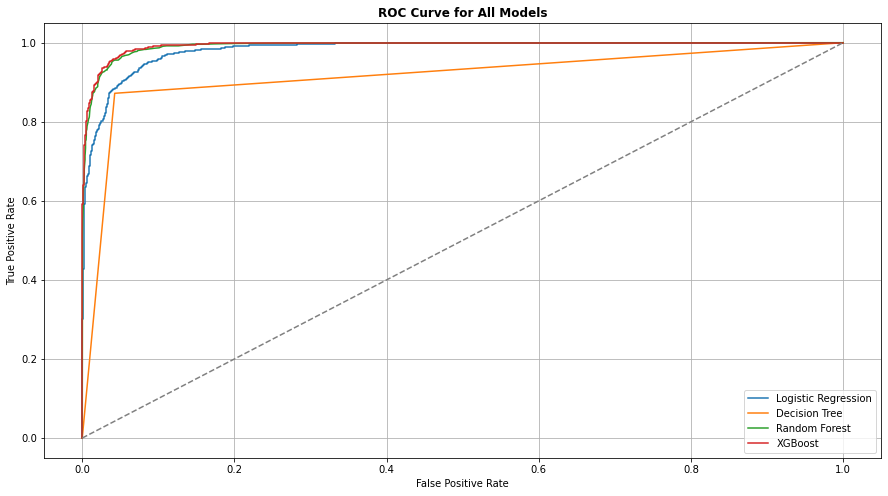

In [60]:

# Binarize the y_test for ROC curve (assuming 4 classes: 0 to 3)
y_test_bin = label_binarize(y_test.values.ravel() if hasattr(y_test, 'values') else y_test.ravel(), classes=[0, 1, 2, 3])

# Define models in a dictionary
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

# Select features
X_test_scaled_ref = X_test_scaled_df[['CO', 'NO2', 'SO2', 'Population_Density', 'Proximity_to_Industrial_Areas']]
X_train_ref = X_train_resampled_ref
y_train_ref = y_train_resampled_df.values.ravel() if hasattr(y_train_resampled_df, 'values') else y_train_resampled_df.ravel()

# Plotting ROC curves
plt.figure(figsize=(15, 8))

for name, model in models.items():
    model.fit(X_train_ref, y_train_ref)
    y_prob = model.predict_proba(X_test_scaled_ref)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    
    plt.plot(fpr, tpr, label=f'{name}')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Models', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()



### Print out the AUC for each model

In [63]:
# Dictionary to store AUC scores
auc_scores = {}

# Flatten the target 
y_train_flat = y_train_resampled_df.values.ravel() if hasattr(y_train_resampled_df, 'values') else y_train_resampled_df.ravel()

# Fit models and compute AUC
for name, model in models.items():
    model.fit(X_train_resampled_ref, y_train_flat)
    y_prob = model.predict_proba(X_test_scaled_ref)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    auc_score = auc(fpr, tpr)

    # Store and print AUC
    auc_scores[name] = auc_score
    print(f'{name} AUC score: {auc_score}')


Logistic Regression AUC score: 0.982286
Decision Tree AUC score: 0.9186666666666667
Random Forest AUC score: 0.9915410000000001
XGBoost AUC score: 0.9934746666666667


### Model Selection Justification

- Given the multiclass nature of the Air Quality target (Good, Moderate, Poor, Hazardous), macro recall is the most suitable metric. It emphasizes correctly identifying all classes, especially reducing false negatives, which is crucial since misclassifying Poor or Hazardous air as safer levels can pose serious health risks.

- While XGBoost slightly outperformed Random Forest in AUC, Random Forest had a marginally better recall score (0.005 higher), indicating it's more effective at capturing all true cases,especially the dangerous ones.

- Since false positives (predicting worse than actual) are less risky than false negatives in this context, Random Forest is preferred for its better recall and reliability in detecting harmful air quality.


In [64]:
# fit the Random Forest classifier and use it to predict the test data
rf = RandomForestClassifier(class_weight='balanced',random_state=42,max_samples=0.8)
rf.fit(X_train_resampled_ref, y_train_resampled) 

y_rf_train_pred = rf.predict(X_train_resampled_ref) 
y_rf_test_pred = rf.predict(X_test_scaled_ref)

In [65]:
# Test for overfitting or underfitting

train_recall_score = recall_score(y_train_resampled_df, y_rf_train_pred, average='macro')
test_recall_score = recall_score(y_test, y_rf_test_pred, average='macro')

print(f' The Recall score for train data is : {train_recall_score}')
print(f' The Recall score for test data is : {test_recall_score}')


 The Recall score for train data is : 0.9995285983658077
 The Recall score for test data is : 0.8907231420864763


- The model appears to be overfitting, as indicated by the noticeable gap between the training recall score and the test recall score.

- It performs exceptionally well on the training data but struggles with new, unseen data, implying it may be learning the training data too closely instead of capturing general patterns.

### Use GridSearchCV to fine tune the model

In [50]:
# Create the grid of parameters to search
param_grid = {
    'n_estimators': [50, 100, 150],                 # fewer trees reduce overfitting
    'max_depth': [4, 6, 8],                         # shallower trees generalize better
    'min_samples_split': [5, 10],                   # higher values prevent overgrowth
    'min_samples_leaf': [3, 5, 7],                  # force leaves to generalize
    'max_features': ['sqrt', 'log2', 0.4, 0.6],     # reduce tree correlation
    'bootstrap': [True],                            # essential for random sampling
    'max_samples': [0.6, 0.7, 0.8]                  # subsample data for less variance
}

# Grid Search using macro recall
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='recall_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train_resampled_ref, y_train_resampled)

# Best model
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate
train_pred = best_rf.predict(X_train_resampled_ref)
test_pred = best_rf.predict(X_test_scaled_ref)

train_recall = recall_score(y_train_resampled, train_pred, average='macro')
test_recall = recall_score(y_test, test_pred, average='macro')
gap = abs(train_recall - test_recall)

print(f"Training Recall Score: {train_recall}")
print(f"Test Recall Score: {test_recall}")
print(f"Recall Score Gap: {gap}")

# Check for overfitting
if train_recall - test_recall > 0.05:
    print(" Potential overfitting detected: The model performs significantly better on training data.")
else:
    print(" No significant overfitting detected: The model generalizes well to unseen data.")



Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'max_samples': 0.6, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 150}
Training Recall Score: 0.9219044626021371
Test Recall Score: 0.8802948125914674
Recall Score Gap: 0.04160965001066974
 No significant overfitting detected: The model generalizes well to unseen data.


### Visualize a confusion matrix to evaluate the model’s performance on unseen test data

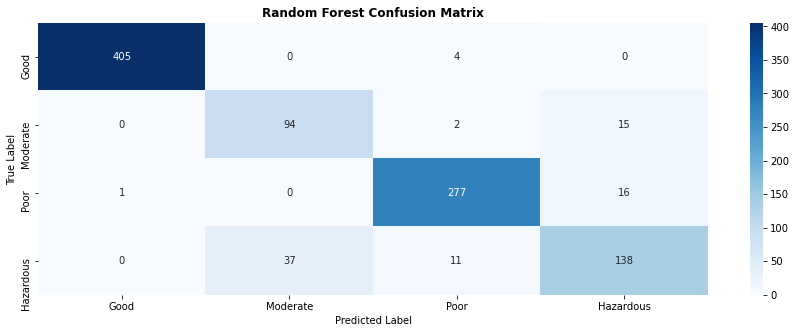

In [67]:
# Predict on the test data
y_rf_test_pred = best_rf.predict(X_test_scaled_ref)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_rf_test_pred)
labels = ['Good', 'Moderate', 'Poor', 'Hazardous']

# Plot as a heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Random Forest Confusion Matrix', fontweight= 'bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Confusion Matrix Findings:

- The model accurately predicts the 'Good' air quality class, with 405 out of 409 instances correctly classified, indicating excellent performance for this category.

- The 'Poor' category also shows strong performance with 277 correct predictions, though 16 instances were incorrectly labeled as 'Hazardous' and 1 as 'Good'.

- For the 'Moderate' class, the model made 94 correct predictions, but 15 instances were misclassified as 'Hazardous' and 2 as 'Poor', suggesting moderate performance.

- The 'Hazardous' class exhibits the highest rate of misclassification, with only 138 correct predictions, while 37 were predicted as 'Moderate' and 11 as 'Poor', indicating that the model struggles most with this category.


### Print out the Classification Report and analyze the findings

In [66]:
# Print the classification report

print('Random Forest Classification Report:')
print(classification_report(y_test, y_rf_test_pred, target_names=['Good', 'Moderate', 'Poor', 'Hazardous']))


Random Forest Classification Report:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       409
    Moderate       0.73      0.87      0.80       111
        Poor       0.96      0.94      0.95       294
   Hazardous       0.82      0.75      0.79       186

    accuracy                           0.92      1000
   macro avg       0.88      0.89      0.88      1000
weighted avg       0.92      0.92      0.92      1000



#### Class-wise Performance:

**Good**

Precision = 1.00

Recall = 0.99

F1-score = 0.99

The model performs exceptionally well on this class, identifying almost all instances correctly with minimal false negatives and no false positives.

**Moderate**

Precision = 0.72

Recall = 0.85

F1-score = 0.78

This class shows moderate performance. While the model retrieves most actual “Moderate” instances (85% recall), precision is lower, indicating a higher false positive rate, some non-Moderate instances are incorrectly classified as Moderate.

**Poor**

Precision = 0.94

Recall = 0.94

F1-score = 0.94

The model demonstrates high accuracy and consistency for this class. Both false positives and false negatives are relatively low, suggesting this class is well learned and generalizes effectively.

**Hazardous**

Precision = 0.82

Recall = 0.74

F1-score = 0.78

The model performs fairly well but struggles more with recall, missing a notable portion of actual Hazardous cases. This suggests misclassifications toward nearby classes, such as “Poor” or “Moderate.”

#### Overall Metrics

Accuracy: 0.91

Macro Average F1-score: 0.87

Weighted Average F1-score: 0.91

These scores indicate that the model performs well overall, with slightly lower consistency in predicting the “Moderate” and “Hazardous” categories. Further tuning or addressing class imbalance may improve performance for these classes.


### Visualizing Feature Importance from the Random Forest Model

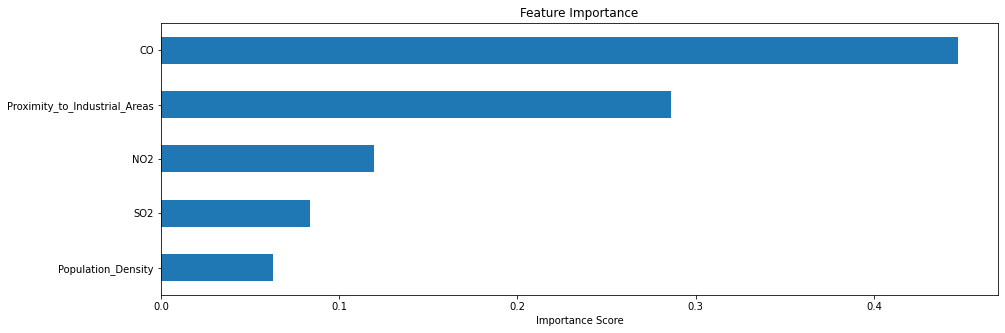

In [69]:
plt.figure(figsize=(15,5))

feature_importance = pd.Series(best_rf.feature_importances_, index=X_train_resampled_ref.columns)
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()

#### Interpretation of the Feature Importance Plot:

- CO has the highest importance score, meaning it is the most influential feature in determining air quality levels. The model relies heavily on this variable for its predictions.

- NO₂ is the second most important feature. It has a significant impact but less than CO.

- SO₂ comes third, indicating a moderate contribution to the model.

- Population Density and Proximity to Industrial Areas have lower importance scores, suggesting that they play a smaller role in the model's decision-making process compared to the pollutants.

#### What This Means:

- Air pollutants like CO, NO₂, and SO₂ are the most critical factors affecting air quality, which aligns well with domain knowledge.

- Demographic/environmental variables like population density and industrial proximity are less influential, though still relevant.

#### Recommendation:

- Focus on controlling or monitoring the top pollutants (especially CO and NO₂) to improve air quality predictions or to develop actionable interventions.